# Detecção de Fraudes em Cartões de Crédito
Nome original: Credit Card Transactions Fraud Detection Dataset.  

Simulação de Transações em Cartões de Crédito através do Sparkov.

Este é um banco de dados simulado que contém transações legítimas e fraudulentas entre 1° de Janeiro de 2019 e 31 de Dezembro de 2020. Estão contidas transações em cartões de 1000 clientes, cujas operações foram realizadas em uma amostra de 800 comerciantes. 


Mais informações em: <https://www.kaggle.com/datasets/kartik2112/fraud-detection?select=fraudTest.csv>

Tutorial do Seaborn: <https://seaborn.pydata.org/tutorial/distributions.html#tutorial-kde>

Tutorial Plotly: <https://plotly.github.io/plotly.py-docs/index.html>

## Importando as Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from dash import Dash, html, dcc

## Explorando a Base de Dados

In [2]:
test = pd.read_csv('fraudTest.csv') 
train = pd.read_csv("fraudTrain.csv")

In [3]:
train.sample(5)

Unnamed: 0 trans_date_trans_time            cc_num  \
742979      742979   2019-11-13 23:07:02  4450831335606294   
82984        82984   2019-02-18 16:28:25  4926376199189801   
668294      668294   2019-10-12 09:01:48    38859492057661   
825819      825819   2019-12-09 17:17:21    30408301059761   
127329      127329   2019-03-11 12:51:02  4653879239169997   

                                   merchant       category    amt    first  \
742979                    fraud_Kerluke Inc       misc_net   7.70    Donna   
82984                  fraud_Lemke and Sons         travel   8.01   Claire   
668294                fraud_Cummerata-Jones  gas_transport  60.30   Edward   
825819  fraud_Schumm, McLaughlin and Carter    food_dining   2.45  Brandon   
127329                fraud_Bashirian Group   shopping_net   5.69   Monica   

           last gender                          street  ...      lat  \
742979    Davis      F              6760 Donovan Lakes  ...  34.5906   
82984     Davis      F  83685 Matthew Center Suite 870  ...  36.3011   
668294  Sanchez      M        594 White Dale Suite 530  ...  42.1808   
825819  Pittman      M               2881 Frey Village  ...  33.3364   
127329   Tucker      F           302 Christina Islands  ...  37.0581   

            long  city_pop                          job         dob  \
742979  -95.3800      1760    Occupational psychologist  1972-01-20   
82984   -91.5281      4726               Pharmacologist  1977-06-07   
668294 -112.2620      4154  Nature conservation officer  1962-01-19   
825819  -80.1859      4471       Occupational hygienist  1973-10-09   
127329  -86.1938      6841            Therapist, sports  1999-06-06   

                               trans_num   unix_time  merch_lat  merch_long  \
742979  92cf5d26beca8841e77812d3cae6c561  1352848022  35.489562  -95.091284   
82984   9d67be2bcfa9a90eb11a6925b55c971a  1329582505  35.707267  -90.649525   
668294  855d84ca06f6e650932a30c0c02476e3  1350032508  43.178772 -111.732297   
825819  7cf265f3984dd853bf57cc5314d5aa8c  1355073441  33.679687  -79.775796   
127329  ba9ca7b922196b83a3b62f491c557cbb  1331470262  36.555233  -85.359590   

        is_fraud  
742979         0  
82984          0  
668294         0  
825819         0  
127329         0  

[5 rows x 23 columns]

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [5]:
train.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

#### A base de dados aparentemente está limpa, não existem valores nulos, e as colunas estão aparentemente em um formato adequado. 
#### Porém, a base não é fornecida juntamente com um dicionário dos dados, por isso não temos certeza do que representa cada atributo.

## Feature Engeneering

In [3]:
train.rename(columns={"trans_date_trans_time":"time"}, inplace = True)
train["time"] = pd.to_datetime(train.time, format = "%Y-%m-%d %H:%M")

In [4]:
train["name"] = train["first"] +" " + train["last"] + " - " + train["job"]

In [5]:
# Avaliando o fórum, descobri que "dob" é uma sigla para "day of birth",
# que indica a data de nascimento da pessoa, e consequentemente sua idade.
train["dob"] = pd.to_datetime(train.dob, format = "%Y-%m-%d %H:%M")
train['age'] = dt.date.today().year - pd.to_datetime(train['dob']).dt.year

In [6]:
# Temos as variáveis "lat", "long", "merch_lat" e "merch_long". 
# Essas variáveis provavelmente se referem a posição do consumidor e do comerciante! 
# Dessa forma, podemos analizar a distância entre ambos:
train["distance"] = ((train.lat - train.merch_lat)**2 + (train.long - train.merch_long)**2)**(1/2)

In [7]:
train.drop(["first", "last", "Unnamed: 0", "cc_num", "street", 
            "zip", "trans_num", "unix_time", "dob" ], 
           axis = 1, 
           inplace = True)

## Visualização 

In [8]:
fraud_number = train.is_fraud[train.is_fraud == 1].count()

print(f"Na base de dados temos um total de {fraud_number} operações fraudulentas.")
print(f"Isso corresponde a {100*fraud_number/len(train):.2f}% da base de dados.")

Na base de dados temos um total de 7506 operações fraudulentas.
Isso corresponde a 0.58% da base de dados.


### Fraudes por Valor Transacionado

Text(0.5, 0.98, 'Fraudes por Valor Transacionado')

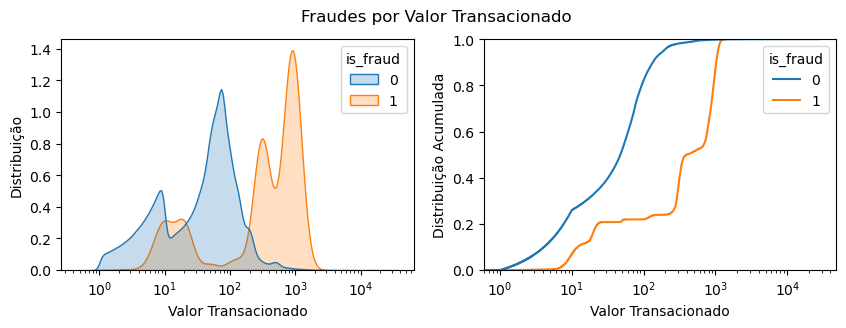

In [17]:
a, a_axes = plt.subplots(1,2, figsize=(10,3))
sns.kdeplot(data=train, x = "amt", hue = "is_fraud", common_norm=False, fill = True, log_scale=True, ax = a_axes[0])
sns.ecdfplot(data=train, x = "amt", hue = "is_fraud", log_scale=True, ax = a_axes[1])

a_axes[0].set(xlabel = "Valor Transacionado", ylabel = "Distribuição")
a_axes[1].set(xlabel = "Valor Transacionado", ylabel = "Distribuição Acumulada")

a.suptitle('Fraudes por Valor Transacionado')

#### Podemos identificar uma clara distinção entre operações normais e operações fraudulentas avaliando o valor transacionado.
#### Podemos identificar dois picos de tendências nas operações fraudulentas: [80 - 130] e [200 - 1200]
#### A maioria das operações não fraudulentas encontram-se na faixa de [0 - 300].

In [13]:
#sns.kdeplot(data = train, x = "amt", hue = "is_fraud", common_norm=False, fill = True, log_scale=True);

In [14]:
#sns.ecdfplot(train, x = "amt", hue = "is_fraud", log_scale=True);

In [15]:
a1 = px.box(train, x = "amt", color = "is_fraud", log_x = True, 
                points = False,
            title="Distribuição de Fraudes por Valor Transacionado",
            labels = {"amt": "Valor Transacionado (escala logarítmica)", "is_fraud": "Ocorrência de Fraudes", "y": "Porcentagem"},
            template="simple_white")
a1.write_html("graphs/fraudes_por_valor_box.html")
#a1

In [16]:
a2 = px.ecdf(train, x = "amt", color = "is_fraud", log_x = True,
            title="Distribuição de Fraudes por Valor Transacionado",
            labels = {"amt": "Valor Transacionado", "is_fraud": "Ocorrência de Fraudes", "y": "Porcentagem"},
            template="simple_white")
a2.write_html("graphs/fraudes_por_valor_ecdf.html")
#a2

### Fraudes por Idade

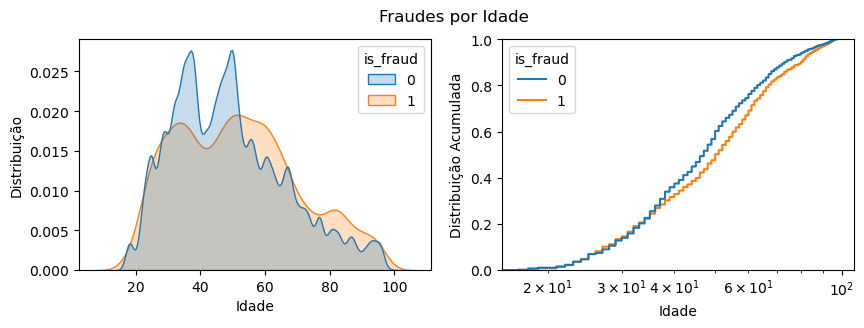

In [17]:
b, axes = plt.subplots(1,2, figsize=(10,3))
sns.kdeplot(data=train, x = "age", hue = "is_fraud", common_norm=False, fill = True, ax = axes[0])
sns.ecdfplot(data=train, x = "age", hue = "is_fraud", log_scale=True, ax = axes[1]);

axes[0].set(xlabel = "Idade", ylabel = "Distribuição")
axes[1].set(xlabel = "Idade", ylabel = "Distribuição Acumulada");

b.suptitle('Fraudes por Idade');


#### Avaliando o gráfico, podemos considerar uma tendência de sujeição à fraude levemente maior em pessoas com mais de 40 anos.

In [18]:
#sns.kdeplot(data=train, x = "age", hue = "is_fraud", common_norm=False, fill = True)

In [19]:
#sns.ecdfplot(data=train, x = "age", hue = "is_fraud", log_scale=True)

In [20]:
b1 = px.violin(train, x = "age", color = "is_fraud", log_x = True, violinmode = "overlay",  range_y = [0, .3],
            title="Distribuição de Fraudes por Idade",
            labels = {"age": "Idade (escala logarítmica)", "is_fraud": "Ocorrência de Fraudes", "y": "Porcentagem"},
            template="simple_white")
b1.write_html("graphs/fraudes_por_idade_kde.html")
#b1

In [21]:
b2 = px.ecdf(train, x = "age", color = "is_fraud", log_x = True,
            title="Distribuição de Fraudes por Idade",
            labels = {"age": "Idade", "is_fraud": "Ocorrência de Fraudes", "y": "Porcentagem"},
            template="simple_white")
b2.write_html("graphs/fraudes_por_idade_ecdf.html")
#b2

In [22]:
b3 = px.box(train, x = "age", color = "is_fraud", log_x = True, 
                points = False,
            title="Distribuição de Fraudes por Idade",
            labels = {"age": "Idade (escala logarítmica)", "is_fraud": "Ocorrência de Fraudes", "y": "Porcentagem"},
            template="simple_white")
b3.write_html("graphs/fraudes_por_idade_box.html")
#b3

### Valor Transacionado e Idade

In [23]:
#c = sns.JointGrid(data=train, x="age", y="amt", hue = "is_fraud")
#c.plot_joint(sns.scatterplot, s=20, alpha=.5)
#c.plot_marginals(sns.kdeplot, common_norm=False, fill = True, log_scale=True)

#### Sim! O gráfico é uma bagunça! Justamente por isso podemos dizer que não é possível identificar uma relação entre a idade e o valor transacionado. Pessoas de diferentes idades possuem gastos variados e dispersos.

## Fraudes por Gênero

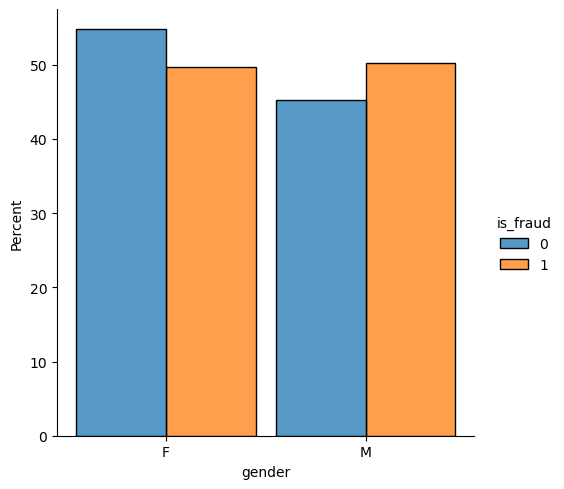

In [24]:
d = sns.displot(data=train, 
            x = "gender",
            hue = "is_fraud",  
            color = "blue",
            stat='percent',
            multiple='dodge',
            common_norm=False,
            shrink = 0.9
)

In [25]:
d = px.histogram(train, x = "gender", color = "is_fraud", histnorm ="percent", barmode="group",
            title="Distribuição de Fraudes por Gênero",
            labels = {"gender": "Gênero", "is_fraud": "Ocorrência de Fraudes", "y": "Porcentagem"},
            template="simple_white")
d.write_html("graphs/fraudes_por_genero.html")
#d

#### Apesar de termos menos homens que mulheres em nossa base de dados, é possível observar que a quantidade de fraudes envolvendo os dois gêneros é praticamente a mesma.

#### Assim, existe uma maior tendência a tentativas de fraude se o indivíduo for do sexo masculino.

### Fraudes por Pessoa

In [26]:
# Obtendo a quantidade fraudada por cada vitma
victim_frauds = train.loc[train.is_fraud == 1].groupby("name").count()
victim_frauds = victim_frauds["is_fraud"].reset_index().sort_values("is_fraud", ascending = False)
victim_frauds.rename(columns={"is_fraud":"fraud_count"}, inplace = True)
victim_frauds

name  fraud_count
545                Micheal Walters - Freight forwarder           19
120                       Chelsea Silva - Set designer           19
745  Whitney Gallagher - Conservation officer, hist...           18
427                  Kelsey Richards - Arboriculturist           16
503                  Mark Wood - Engineer, electronics           16
..                                                 ...          ...
754                          William Perry - Herbalist            2
352                          Jessica Ward - Contractor            2
601  Rebecca Erickson - English as a second languag...            2
417   Katherine Tucker - Clothing/textile technologist            2
640                  Sabrina Nolan - Chemical engineer            2

[762 rows x 2 columns]

#### Podemos identificar que algumas pessoas sofreram fraudes reiteradamente.
#### Também podemos verificar se as linhas estão duplicadas ou não através do código abaixo. Não foram identificadas linhas duplicadas.

In [27]:
#train.drop_duplicates()
#train[train.duplicated(subset="name")].sort_values("name")

In [28]:
# Contando a quantidade de vitimas que sofreram o mesmo número de fraudes
victim_fraud_counts = pd.DataFrame(victim_frauds.fraud_count.value_counts()).reset_index()
victim_fraud_counts.rename(columns = {"index":"frauds_suffered","fraud_count":"occurrences"}, inplace = True)
#victim_fraud_counts

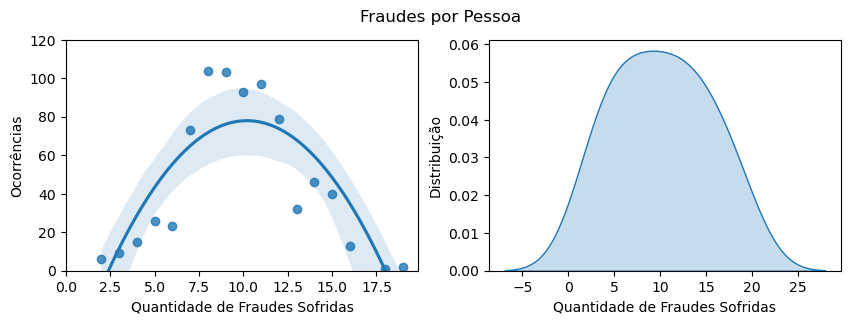

In [29]:
e, axes = plt.subplots(1,2, figsize=(10,3))
sns.regplot(data=victim_fraud_counts, y = "occurrences", x = "frauds_suffered", order=2, ax = axes[0])
sns.kdeplot(data=victim_fraud_counts, x = "frauds_suffered", common_norm=False, fill = True, ax = axes[1])

axes[0].set(xlabel = "Quantidade de Fraudes Sofridas", ylabel = "Ocorrências")
axes[0].set_ylim(0,120)
axes[0].set_xlim(0,)
axes[1].set(xlabel = "Quantidade de Fraudes Sofridas", ylabel = "Distribuição")

e.suptitle('Fraudes por Pessoa');

#### Se a pessoa está propensa a ser fraudada, essa pessoa será fraudada em média 10 vezes.
#### A distribuição das fraudes sofridas segue a curva normal.

In [30]:
#k = sns.lmplot(data=victim_fraud_counts, y = "occurrences", x = "frauds_suffered", order=2)
#k.axes[0,0].set_ylim(0,120)
#k.axes[0,0].set_xlim(0,)

In [31]:
#sns.kdeplot(data=victim_fraud_counts, x = "frauds_suffered", common_norm=False, fill = True)

In [32]:
e1 = px.scatter(victim_fraud_counts, y = "occurrences", x = "frauds_suffered",
                title="Distribuição de Fraudes por Pessoa",
                labels = {"occurrences": "Ocorrência", "frauds_suffered": "Fraudes Sofridas por Pessoa"},
                template="simple_white",
                trendline="lowess")
e1.write_html("graphs/fraudes_por_pessoa_scatter.html")
#e1.show()

In [33]:
e2 = px.violin(victim_fraud_counts, x = "frauds_suffered", range_y = [0, .3],
            title="Distribuição de Fraudes por Pessoa",
            labels = {"frauds_suffered": "Quantidade de Fraudes Sofridas"},
            template="simple_white")
e2.write_html("graphs/fraudes_por_pessoa_kde.html")
#e2

### Tempo de Repetição da Fraude - Vítima

In [34]:
victim_frequency = pd.DataFrame()
for victims in victim_frauds.name:
    vfraud_times = train.loc[(train.name == victims) & (train.is_fraud == 1), "time"]
    vfraud_times = pd.DataFrame(vfraud_times).sort_values("time").diff().dropna().reset_index(drop=True)
    victim_frequency = pd.concat([victim_frequency, vfraud_times])
#victim_frequency.head()

(0.0, 26.60629961346403)

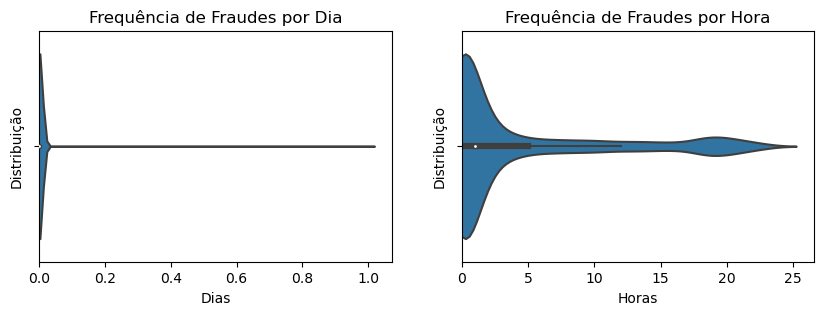

In [35]:
f, axes = plt.subplots(1,2, figsize=(10,3))
sns.violinplot(x = victim_frequency["time"].dt.days[(victim_frequency["time"].dt.days >= 0)], ax = axes[0])
sns.violinplot(x = victim_frequency["time"].dt.components.hours, ax = axes[1]);

axes[0].set(title="Frequência de Fraudes por Dia", xlabel = "Dias", ylabel = "Distribuição")
axes[0].set_xlim(0)
axes[1].set(title="Frequência de Fraudes por Hora", xlabel = "Horas", ylabel = "Distribuição")
axes[1].set_xlim(0)

#### O tempo de repetição da fraude na vítima é muito curto! A vítima pode ser fraudada diversas vezes na mesma hora!
#### Algumas vezes os fraudadores esperam até de noite para realizar a fraude!

In [36]:
#sns.violinplot(x = victim_frequency["time"].dt.days[(victim_frequency["time"].dt.days >= 0)]);

In [37]:
#sns.violinplot(x = victim_frequency["time"].dt.components.hours);

In [38]:
f1 = px.violin(victim_frequency["time"].dt.components.days, 
          orientation = "h",
          range_x = [0, 1.1],
          points = False,
          title = "Frequência de Repetição de Fraudes (dias)",
          labels = {"value": "Tempo (em dias)", "variable":"Distribuição"},
          template="simple_white")

f1.write_html("graphs/violin_repetição_frauds_dias.html")
#f1

In [39]:
f2 = px.box(victim_frequency["time"].dt.components.days, 
          orientation = "h",
          range_x = [0, 1.1],
          points = False,
          title = "Frequência de Repetição de Fraudes (dias)",
          labels = {"value": "Tempo (em dias)", "variable":"Distribuição"},
          template="simple_white")

f2.write_html("graphs/box_repetição_frauds_dias.html")
#f2

In [40]:
f3 = px.violin(victim_frequency["time"].dt.components.hours, 
          orientation = "h",
          range_x = [0, 25],
          points = False,
          title = "Frequência de Repetição de Fraudes (horas)",
          labels = {"value": "Tempo (em horas)", "variable":"Distribuição"},
          template="simple_white")

f3.write_html("graphs/violin_repetição_frauds_horas.html")
#f3

In [41]:
f4 = px.box(victim_frequency["time"].dt.components.hours, 
          orientation = "h",
          range_x = [0, 25],
          points = False,
          title = "Frequência de Repetição de Fraudes (horas)",
          labels = {"value": "Tempo (em horas)", "variable":"Distribuição"},
          template="simple_white")

f4.write_html("graphs/box_repetição_frauds_horas.html")
#f4

### Fraudes por Distância


In [42]:
g = px.violin(train, y = "distance", color = "is_fraud", box=True,
          title = "Distribuição de Fraudes por Distância entre Consumidor e Comerciante",
          labels = {"is_fraud": "Ocorrência de Fraudes", "distance":"Distribuição da Distância"},
          template="simple_white")

g.write_html("graphs/fraudes_por_distância.html")
#g

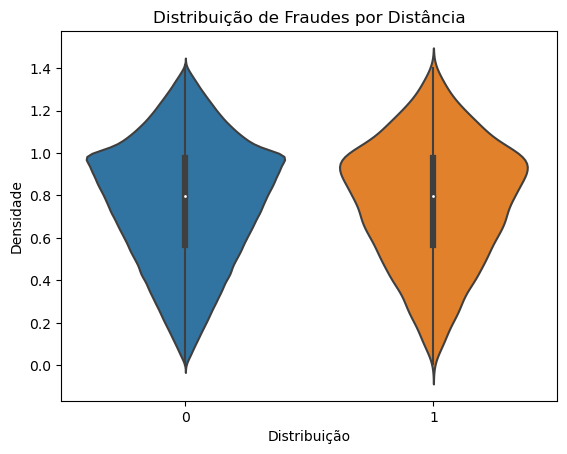

In [43]:
g = sns.violinplot(data=train, y = "distance", x = "is_fraud")
g.set_ylabel("Densidade")
g.set_xlabel("Distribuição")
g.set_title("Distribuição de Fraudes por Distância");

#### Como os dois gráficos possuem uma distribuição praticamente idêntica, não podemos afirmar que existe uma relação entre os casos de fraude e uma maior distância entre usuáriuo e comerciante.

### Fraudes por Comerciante
Vamos avaliar a quantidade de vezes que um mesmo comerciante tende a praticar uma fraude.

In [44]:
# Obtendo a quantidade fraudada por cada comerciante
merchant_frauds = train.loc[train.is_fraud == 1].groupby("merchant").count()
merchant_frauds = merchant_frauds["is_fraud"].reset_index().sort_values("is_fraud", ascending = False)
merchant_frauds.rename(columns={"is_fraud":"fraud_count"}, inplace = True)
#merchant_frauds

In [45]:
# Contando a quantidade de comerciantes que realizaram o mesmo número de fraudes
fraud_counts = pd.DataFrame(merchant_frauds.fraud_count.value_counts()).reset_index()
fraud_counts.rename(columns={"index":"merchant_frauds", "fraud_count": "occurrences"}, inplace = True)
#fraud_counts

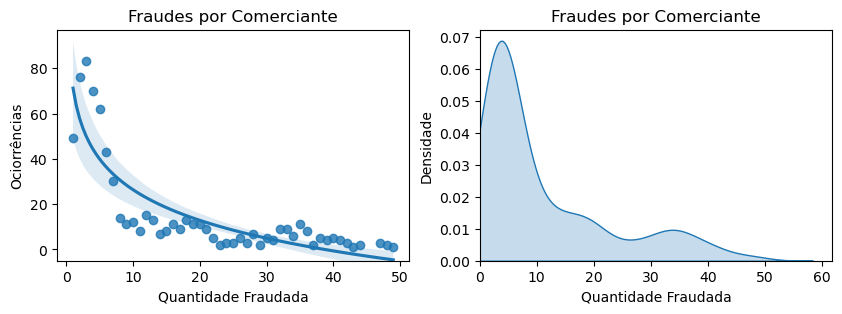

In [46]:
h, axes = plt.subplots(1,2, figsize=(10,3))
sns.regplot(data=fraud_counts, y = "occurrences", x = "merchant_frauds", logx=True, ax = axes[0])
sns.kdeplot(data=merchant_frauds, x = "fraud_count", common_norm=False, fill = True, ax = axes[1]);

axes[0].set(title="Fraudes por Comerciante", xlabel = "Quantidade Fraudada", ylabel = "Ociorrências")
axes[0].set_ylim(-5)
axes[1].set(title="Fraudes por Comerciante", xlabel = "Quantidade Fraudada", ylabel = "Densidade")
axes[1].set_xlim(0);

#### A maioria dos comerciantes que cometem fraudes realizam o esquema até 10 vezes - no período analisado. 
#### É necessário analizar o lapso de tempo entre uma fraude e outra para obter maiores conclusões. 

In [47]:
#sns.lmplot(fraud_counts, y = "occurrences", x = "merchant_frauds", logx=True)

In [48]:
#sns.kdeplot(merchant_frauds, x = "fraud_count", common_norm=False, fill = True)

In [49]:
h1 = px.scatter(fraud_counts, y = "occurrences", x = "merchant_frauds",
                title="Distribuição de Fraudes por Comerciante",
                labels = {"occurrences": "Ocorrência", "frauds_suffered": "Fraudes Cometidas por Comerciante"},
                template="simple_white",
                trendline="ols", trendline_options = dict(log_x=True))
h1.write_html("graphs/fraudes_por_comerciante_scatter.html")
#h1.show()

In [50]:
h2 = px.violin(merchant_frauds, x = "fraud_count", range_y = [0, .3], range_x = [0, 55],
            title="Distribuição de Fraudes por Comerciante",
            labels = {"fraud_count": "Quantidade Fraudada"},
            template="simple_white")
h2.write_html("graphs/fraudes_por_comerciante_kde.html")
#h2

### Tempo de Repetição da Fraude - Comerciante

In [51]:
merchant_frequency = pd.DataFrame()
for merchant in merchant_frauds.merchant:
    fraud_times = train.loc[(train.merchant == merchant) & (train.is_fraud == 1), "time"]
    fraud_times = pd.DataFrame(fraud_times).sort_values("time").diff().dropna().reset_index(drop=True)
    merchant_frequency = pd.concat([merchant_frequency, fraud_times])
#merchant_frequency.head()

(0.0, 112.4279247682848)

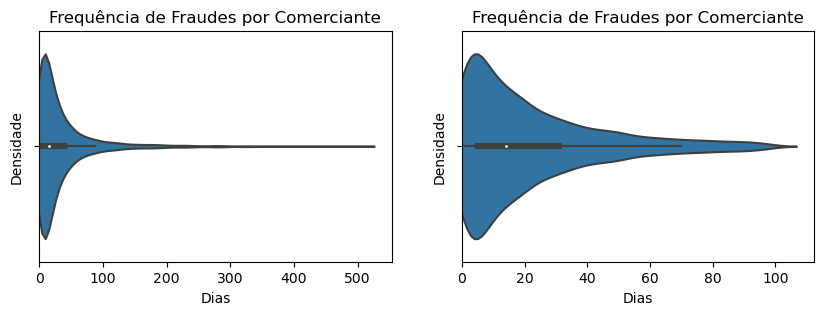

In [52]:
i, axes = plt.subplots(1,2, figsize=(10,3))
sns.violinplot(x = merchant_frequency["time"].dt.days, ax = axes[0])
sns.violinplot(x = merchant_frequency["time"].dt.days[merchant_frequency["time"].dt.days < 100], ax = axes[1]);

axes[0].set(title="Frequência de Fraudes por Comerciante", xlabel = "Dias", ylabel = "Densidade")
axes[0].set_xlim(0)
axes[1].set(title="Frequência de Fraudes por Comerciante", xlabel = "Dias", ylabel = "Densidade")
axes[1].set_xlim(0)

#### A maioria dos comerciantes que cometem fraudes tendem a repetir a fraude em um curto espaço de tempo - menos de 20 dias!
#### Considerando a frequência de fraudes nas vítimas, os comerciantes que cometem mais fraudes executam elas em poucas horas!

In [53]:
#sns.violinplot(x = merchant_frequency["time"][merchant_frequency["time"].dt.days == 0].dt.components.hours);

In [54]:
#sns.violinplot(x = merchant_frequency["time"].dt.days);

In [55]:
#sns.violinplot(x = merchant_frequency["time"].dt.days[merchant_frequency["time"].dt.days < 100]);

In [56]:
i1 = px.violin(merchant_frequency["time"].dt.components.days, 
          orientation = "h",
          range_x = [0,550],
          points = False,
          title = "Frequência de Repetição de Fraudes (dias)",
          labels = {"value": "Tempo (em dias)", "variable":"Distribuição"},
          template="simple_white")    

i1.write_html("graphs/violin_repetição_frauds_comerciante_dias.html")
#i1

In [57]:
i2 = px.box(merchant_frequency["time"].dt.components.days, 
          orientation = "h",
          range_x = [0,550],
          points = False,
          title = "Frequência de Repetição de Fraudes (dias)",
          labels = {"value": "Tempo (em dias)", "variable":"Distribuição"},
          template="simple_white")

i2.write_html("graphs/box_repetição_frauds_comerciante_dias.html")
#i2

In [58]:
i3 = px.violin(merchant_frequency["time"].dt.components.days, 
          orientation = "h",
          range_x = [0,100],
          points = False,
          title = "Frequência de Repetição de Fraudes (dias)",
          labels = {"value": "Tempo (em dias)", "variable":"Distribuição"},
          template="simple_white")

i3.write_html("graphs/violin_repetição_frauds_comerciante_100dias.html")
#i3

In [59]:
i4 = px.box(merchant_frequency["time"].dt.components.days, 
          orientation = "h",
          range_x = [0,100],
          points = False,
          title = "Frequência de Repetição de Fraudes (dias)",
          labels = {"value": "Tempo (em dias)", "variable":"Distribuição"},
          template="simple_white")

i4.write_html("graphs/box_repetição_frauds_comerciante_100dias.html")
#i4

### Fraudes pelo Volume de Vendas

In [60]:
# Quantidade de operações por comerciante
merch_fr = train.groupby("merchant")["is_fraud"].value_counts()
merch_fr = pd.DataFrame(merch_fr).rename(columns = {"is_fraud":"sales"}).reset_index(level="is_fraud")
#merch_fr

In [61]:
# Separando as fraudes das operações normais
merch_frauds = pd.DataFrame()
merch_frauds["frauds"] = merch_fr.loc[merch_fr["is_fraud"] == 1, "sales"]
merch_frauds["normal_transactions"] = merch_fr.loc[merch_fr["is_fraud"] == 0, "sales"]
merch_frauds.reset_index(inplace=True)
#merch_frauds

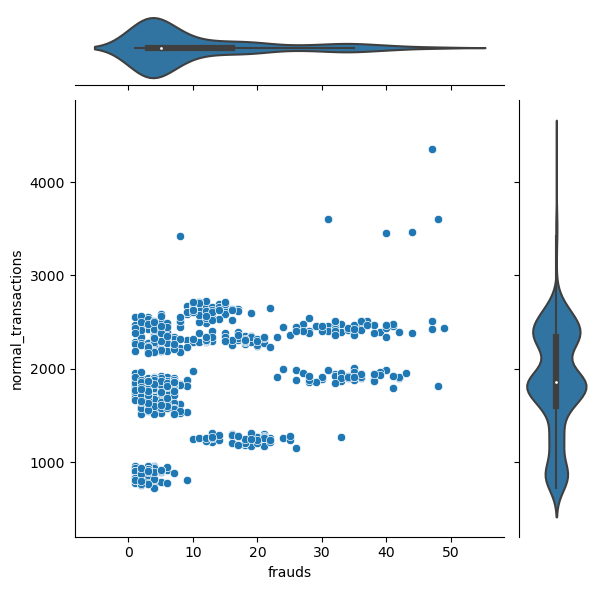

In [62]:
j = sns.JointGrid(data=merch_frauds, y="normal_transactions", x="frauds")
j.plot_joint(sns.scatterplot)
j.plot_marginals(sns.violinplot);

#### Aparentemente existem clústers na relação entre as fraudes e o volume de vendas. Não obtive nenhuma ideia do que pode causar isso.

In [63]:
j = px.scatter(merch_frauds, y = "normal_transactions", x = "frauds",
               marginal_x="box", marginal_y="box",
                title="Distribuição de Transações por Comerciante",
                labels = {"normal_transactions": "Transações Não Fraudulentas",
                          "frauds": "Transações Fraudulentas"},
                template="simple_white")
j.write_html("graphs/transações_por_comerciante_scatter.html")
j.show()

### Fraudes por Categorias

In [64]:
# Obtendo as quantidades de cada categoria:
categories = train.groupby("category")["is_fraud"].value_counts()
categories = pd.DataFrame(categories).rename(columns={"is_fraud":"transactions"}).reset_index(level="is_fraud")
#categories.head()

In [65]:
# Criando o dataset:
fraud_categories = pd.DataFrame()
fraud_categories["frauds"] = categories.loc[categories["is_fraud"] == 1, "transactions"]
fraud_categories["normal_transactions"] = categories.loc[categories["is_fraud"] == 0, "transactions"]
test = fraud_categories.copy()
fraud_categories.reset_index(inplace=True)
#fraud_categories

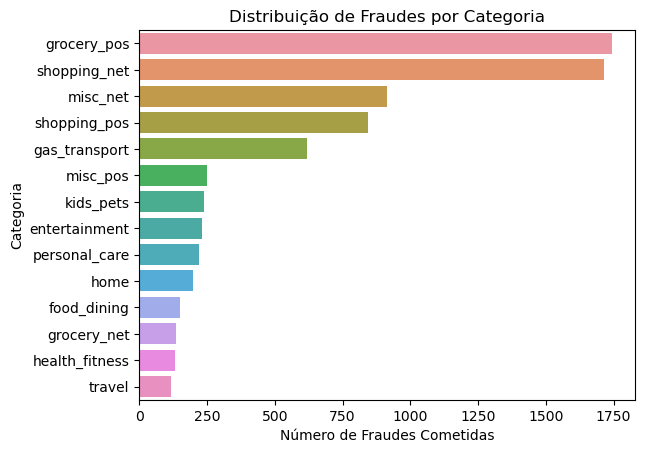

In [66]:
k = sns.barplot(data=fraud_categories.sort_values("frauds", ascending=False),
       y="category",
       x = "frauds",
)
k.set_ylabel("Categoria")
k.set_xlabel("Número de Fraudes Cometidas")
k.set_title("Distribuição de Fraudes por Categoria");

In [67]:
k = px.bar(fraud_categories.sort_values("frauds", ascending=True), x = "frauds", y="category",
            title="Distribuição de Fraudes por Categoria - Ocorrências",
            labels = {"category": "Categoria", "frauds": "Ocorrência de Fraudes"},
            template="simple_white")
k.write_html("graphs/fraudes_por_categoria_oc.html")
#k.show()

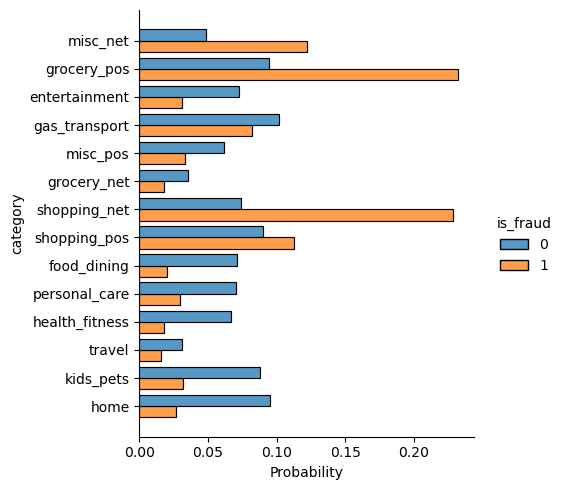

In [68]:
l = sns.displot(train, 
            y = "category", 
            hue = "is_fraud", 
            stat = "probability",
            multiple='dodge',
            common_norm = False,
            bins = 40,
            shrink = 0.8
           
);

In [69]:
l = px.histogram(train, y = "category", color = "is_fraud", histnorm ="percent", barmode="group",
            title="Distribuição de Fraudes por Categoria - Percentual",
            labels = {"category": "Categoria", "is_fraud": "Ocorrência de Fraudes", "percent": "Porcentagem"},
            template="simple_white")

l.update_yaxes(categoryorder = "total ascending")
l.write_html("graphs/fraudes_por_categoria_percent.html")
#l

### Fraudes por Hora

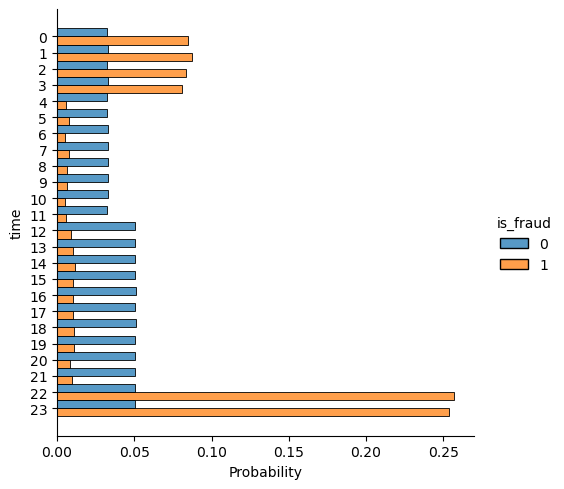

In [70]:
m = sns.displot(train, 
            y = train.time.dt.hour.astype("str"), 
            hue = "is_fraud", 
            stat = "probability",
            multiple='dodge',
            common_norm = False,
            bins = 40
           
);

In [71]:
m = px.histogram(train, y =train.time.dt.hour.astype("str"), color = "is_fraud", histnorm ="percent", barmode="group",
            title="Distribuição de Fraudes por Hora do Dia",
            labels = {"y": "Hora do Dia", "is_fraud": "Ocorrência de Fraudes", "x": "Porcentagem"},
            template="simple_white")

m.update_yaxes(autorange="reversed")

m.write_html("graphs/fraudes_por_hora_dia.html")
#m

#### Esse gráfico é muito interessante! As operações não fraudulentas ocorrem de forma praticamente constante ao longo do dia.
#### Porém, as operações fraudulentas tendem a se concentrar entre as 22h da noite e as 3h da madrugada!

### Fraudes por Dia da Semana

C:\Users\tiago\AppData\Local\Temp\ipykernel_19024\1726655710.py:10: UserWarning:

FixedFormatter should only be used together with FixedLocator



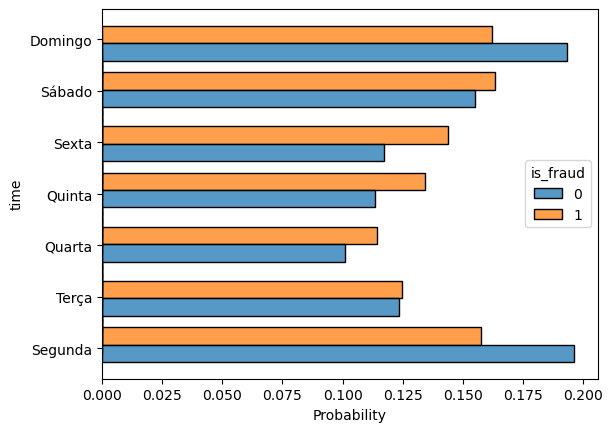

In [72]:
n = sns.histplot(train, 
            y = train.time.dt.dayofweek, 
            hue = "is_fraud",
            stat = "probability",
            multiple='dodge',
            common_norm = False,
            bins = 40,
            shrink = 4.5
)
n.set_yticklabels(["", "Segunda","Terça","Quarta","Quinta","Sexta","Sábado","Domingo", ""]);

In [73]:
n = px.histogram(train, y =train.time.dt.dayofweek, color = "is_fraud", histnorm ="percent", barmode="group",
            title="Distribuição de Fraudes por Dia da Semana",
            labels = {"y": "Dia da Semana", "is_fraud": "Ocorrência de Fraudes", "percent": "Porcentagem"},
            template="simple_white")

n.update_yaxes(autorange="reversed")

n.update_layout(yaxis = dict(tickmode = 'array',
                             tickvals = [0, 1, 2, 3, 4, 5, 6],
                             ticktext = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo']))

n.write_html("graphs/fraudes_por_dia_semana.html")
#n

#### Não é possível indicar um dia da semana que seja mais sujeito a fraudes. A ocorrência de fraudes acompanha a variação das operações ao longo dos dias. 
#### É possível inferir que as pessoas gastam menos durante a semana que no final de semana.

### Fraudes por Mês

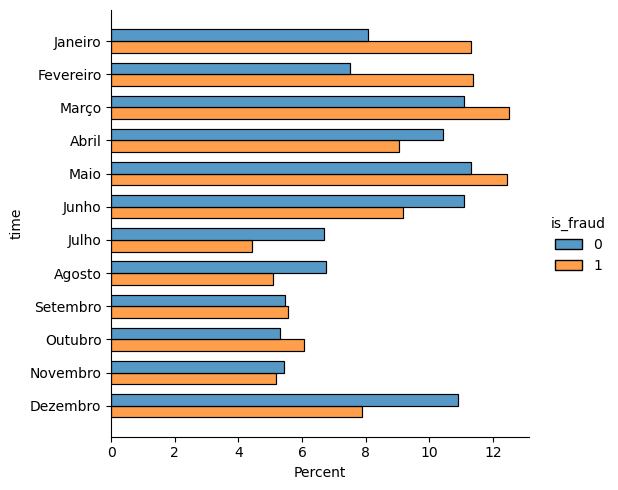

In [74]:
o = sns.displot(train, 
            y = train.time.dt.month.astype("str"), 
            hue = "is_fraud", 
            stat = "percent",
            multiple='dodge',
            common_norm = False,
            bins = 10,
            shrink = 0.7
           
)
o.set_yticklabels(["Janeiro","Fevereiro","Março","Abril",
                       "Maio","Junho","Julho", "Agosto", "Setembro", "Outubro",
                       "Novembro", "Dezembro"]);

In [75]:
o = px.histogram(train, y =train.time.dt.month, color = "is_fraud", histnorm ="percent", barmode="group",
            title="Distribuição de Fraudes por Mês",
            labels = {"y": "Mês", "is_fraud": "Ocorrência de Fraudes", "percent": "Porcentagem"},
            template="simple_white")

o.update_yaxes(autorange="reversed")
o.update_layout(yaxis = dict(
    tickmode = 'array',
    tickvals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    ticktext = ["Janeiro", "Fevereiro","Março","Abril",
                "Maio","Junho","Julho", "Agosto", "Setembro",
                "Outubro", "Novembro", "Dezembro"]))

o.write_html("graphs/fraudes_por_mês.html")
#o

#### Majoritariamente, ao longo do ano, as fraudes acompanham o nível de gastos da população.
#### Porém, existe um aumento expressivo de fraudes em janeiro e fevereiro, quando comparado aos níveis de transações normais.
#### Ou seja, existe um aumento de fraudes após as compras natalinas e festividades de ano novo. Por outro lado, as fraudes diminuem na época do natal.
#### Possivelmente os comerciantes evitam cometer fraudes assim que conseguem as informações dos clientes, esperando alguns meses para cometer o delito.

## Fraudes por População

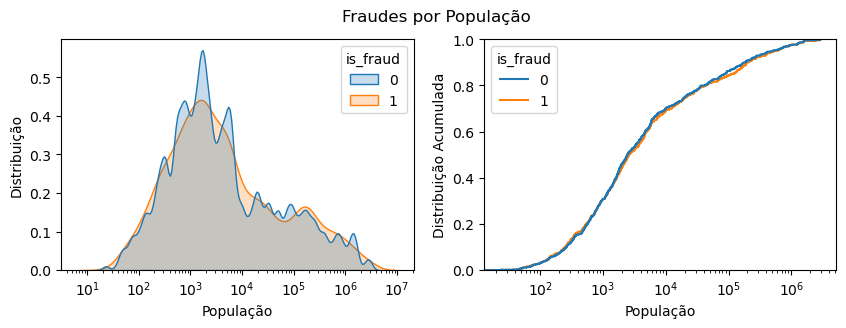

In [76]:
p, axes = plt.subplots(1,2, figsize=(10,3))
sns.kdeplot(data=train, x = "city_pop", hue = "is_fraud", common_norm=False, fill = True, log_scale=True, ax = axes[0])
sns.ecdfplot(data=train, x = "city_pop", hue = "is_fraud", log_scale=True, ax = axes[1]);

axes[0].set(xlabel = "População", ylabel = "Distribuição")
axes[1].set(xlabel = "População", ylabel = "Distribuição Acumulada")

p.suptitle('Fraudes por População');

#### Não há indicios de relação entre a quantidade de fraudes e a quantidade de população.

In [77]:
#sns.kdeplot(train, x = "city_pop", hue = "is_fraud", common_norm=False, fill = True, log_scale=True)

In [78]:
#sns.ecdfplot(train, x = "city_pop", hue = "is_fraud", log_scale=True)

In [79]:
p1 = px.box(train, x = "city_pop", color = "is_fraud", log_x = True, 
                points = False,
            title="Distribuição de Fraudes por População",
            labels = {"city_pop": "População (escala logarítmica)", "is_fraud": "Ocorrência de Fraudes", "y": "Porcentagem"},
            template="simple_white")
p1.write_html("graphs/fraudes_por_população_box.html")
#p1

In [80]:
p2 = px.ecdf(train, x = "city_pop", color = "is_fraud", log_x = True,
            title="Distribuição de Fraudes por População",
            labels = {"city_pop": "População", "is_fraud": "Ocorrência de Fraudes", "y": "Porcentagem"},
            template="simple_white")
p2.write_html("graphs/fraudes_por_city_pop_ecdf.html")
#p2